In [46]:
from pytket.circuit import Circuit, Qubit, OpType, CircBox
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.extensions.qiskit import AerBackend
from pytket.utils import probs_from_counts
from python_package.sudoku import Sudoku
import matplotlib.pyplot as plt
import numpy as np

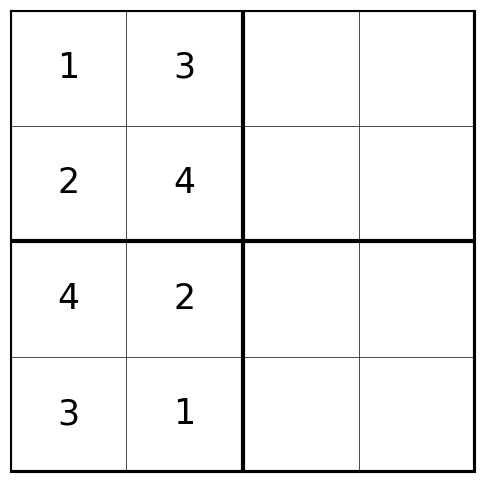

In [3]:
# initialize the thesis 4x4 sudoku example as a Sudoku instance
example_sudoku_4x4 = Sudoku("../../data/4x4sudoku.csv")
example_sudoku_4x4.general_preprocessing()
example_sudoku_4x4.plot_grid()

# **Primitive Encoding**
---
To encode a 4x4 Sudoku, 2 qubits are needed to encode all possible values of each cell, then we need a total of 32 coding qubits for the whole 4x4 sudoku

In [4]:
circ = Circuit()

# Coding qubits
v = circ.add_q_register("V", 32)


# **Idea**
---
To encode a 4x4 Sudoku, 2 qubits are needed to encode all possible values of each cell, then we need a total of 32 coding qubits for the whole 4x4 sudoku, we can focus just in one sub unit at time, then 8 qubits are needed.

## **Grover algorithm without row and column constraints**

In [9]:
circ = Circuit()

# Coding qubits
v = circ.add_q_register("V", 8)

In [10]:
clause_list = [[0, 1], 
               [0, 2],
               [1, 3], 
               [2, 3]]

In [11]:
# Implementation of compare gate

compare_circ = Circuit(7, name="Comp")
compare_circ.CX(0, 4)
compare_circ.CX(2, 4)
compare_circ.CX(1, 5)
compare_circ.CX(3, 5)
compare_circ.CCX(4, 5, 6)
compare_circ.CX(1, 5)
compare_circ.CX(3, 5)
compare_gate = CircBox(compare_circ)

draw(compare_circ)

In [13]:
# Oracle Implementation
compare_qubits = 12

oracle_circ = Circuit(name = "Oracle")

# Coding qubits
v = oracle_circ.add_q_register("V", 8)

# Auxiliar qubits
c = oracle_circ.add_q_register("c", compare_qubits)

# Grover bit
grover_bit = Qubit("grover bit", 0)
oracle_circ.add_qubit(grover_bit)


# Operations between pairs
for i, clause in enumerate(clause_list):
    oracle_circ.add_gate(compare_gate, [v[clause[0]*2], v[clause[0]*2 + 1], v[clause[1]*2], v[clause[1]*2 + 1], c[i*3], c[i*3 +1], c[i*3 + 2]])


oracle_circ.add_gate(OpType.CnX, c.to_list()[2::3] + [grover_bit])


# Reset clause-cheking qubits to 1
for i, clause in enumerate(clause_list):
    oracle_circ.add_gate(compare_gate, [v[clause[0]*2], v[clause[0]*2 + 1], v[clause[1]*2], v[clause[1]*2 + 1], c[i*3], c[i*3 + 1], c[i*3 + 2]])

oracle = CircBox(oracle_circ)

draw(oracle_circ)

In [14]:
#Diffuser Implementation

diffuser_circ = Circuit(name = "Diffuser")

# Coding qubits
v = diffuser_circ.add_q_register("V", 8)

# Grover bit
grover_bit = Qubit("grover bit", 0)
diffuser_circ.add_qubit(grover_bit)

# Apply Hadamard transform
for qubit in v.to_list():
    diffuser_circ.H(qubit)
    diffuser_circ.X(qubit)

diffuser_circ.add_gate(OpType.CnX, v.to_list() + [grover_bit])

for qubit in v.to_list():
    diffuser_circ.X(qubit)
    diffuser_circ.H(qubit)

diffuser = CircBox(diffuser_circ)

draw(diffuser_circ)

In [25]:
# Circuit initialization

circ = Circuit()

# Coding qubits
v = circ.add_q_register("V", 8)

# Auxiliar qubits
c = circ.add_q_register("c", 12)

# Grover bit
grover_bit = Qubit("grover bit", 0)
circ.add_qubit(grover_bit)

# Classical register
k = circ.add_c_register("cbits", 8)

# Equal superposition state
for qubit in v.to_list():
    circ.H(qubit)

# Grover's bit |-> initialization
circ.X(grover_bit)
circ.H(grover_bit)

circ.add_barrier(circ.qubits)

# Grover's first iteration
circ.add_gate(oracle, circ.qubits)
circ.add_gate(diffuser, v.to_list() + [grover_bit])

circ.add_barrier(circ.qubits)

# Grover's second iteration
circ.add_gate(oracle, circ.qubits)
circ.add_gate(diffuser, v.to_list() + [grover_bit])

circ.add_barrier(circ.qubits)

# Grover's second iteration
circ.add_gate(oracle, circ.qubits)
circ.add_gate(diffuser, v.to_list() + [grover_bit])

circ.add_barrier(circ.qubits)

for i in range(8):
    circ.Measure(v[i], k[i])

draw(circ)

In [26]:
backend = AerBackend()
compiled_circ = backend.get_compiled_circuit(circ)

handle = backend.process_circuit(compiled_circ, n_shots=1024)
counts = backend.get_result(handle).get_counts()

In [27]:
def convert_tuple_to_decimal_pairs(original_tuple):
    # Ensure the original tuple has 8 elements
    if len(original_tuple) != 8:
        raise ValueError("The original tuple must have exactly 8 elements.")
    
    # Group the tuple into pairs and convert each pair to its decimal value
    decimal_values = []
    for i in range(0, len(original_tuple), 2):
        # Each pair
        pair = original_tuple[i:i+2]
        # Convert the pair from binary to decimal
        decimal_value = pair[0] * 2 + pair[1]
        # Append the decimal value to the list
        decimal_values.append(decimal_value)
    
    # Convert the list of decimal values to a tuple
    decimal_tuple = tuple(decimal_values)
    
    return decimal_tuple

In [33]:
data = probs_from_counts(counts)

for key, value in data.items():
    if value > 0.006:
        print(convert_tuple_to_decimal_pairs(key), value)

(0, 1, 1, 0) 0.0078125
(0, 1, 1, 3) 0.0087890625
(0, 1, 2, 0) 0.0107421875
(0, 1, 2, 3) 0.0078125
(0, 1, 3, 0) 0.0078125
(0, 1, 3, 2) 0.0087890625
(0, 2, 1, 3) 0.009765625
(0, 2, 2, 0) 0.009765625
(0, 2, 2, 1) 0.0078125
(0, 2, 2, 3) 0.0087890625
(0, 2, 3, 0) 0.0087890625
(0, 2, 3, 1) 0.009765625
(0, 3, 1, 0) 0.0087890625
(0, 3, 1, 2) 0.0068359375
(0, 3, 2, 0) 0.0068359375
(0, 3, 2, 1) 0.0078125
(0, 3, 3, 0) 0.01171875
(0, 3, 3, 2) 0.009765625
(1, 0, 0, 3) 0.0078125
(1, 0, 2, 3) 0.0068359375
(1, 0, 3, 1) 0.0078125
(1, 0, 3, 2) 0.0068359375
(1, 2, 0, 1) 0.0126953125
(1, 2, 2, 0) 0.0107421875
(1, 2, 2, 1) 0.009765625
(1, 2, 2, 3) 0.01171875
(1, 2, 3, 0) 0.0068359375
(1, 3, 0, 1) 0.0126953125
(1, 3, 2, 0) 0.0068359375
(1, 3, 2, 1) 0.009765625
(1, 3, 3, 2) 0.009765625
(2, 0, 0, 1) 0.009765625
(2, 0, 0, 2) 0.009765625
(2, 0, 0, 3) 0.0068359375
(2, 0, 1, 2) 0.0087890625
(2, 0, 1, 3) 0.0087890625
(2, 0, 3, 1) 0.0078125
(2, 0, 3, 2) 0.0107421875
(2, 1, 0, 2) 0.0078125
(2, 1, 0, 3) 0.0087890625


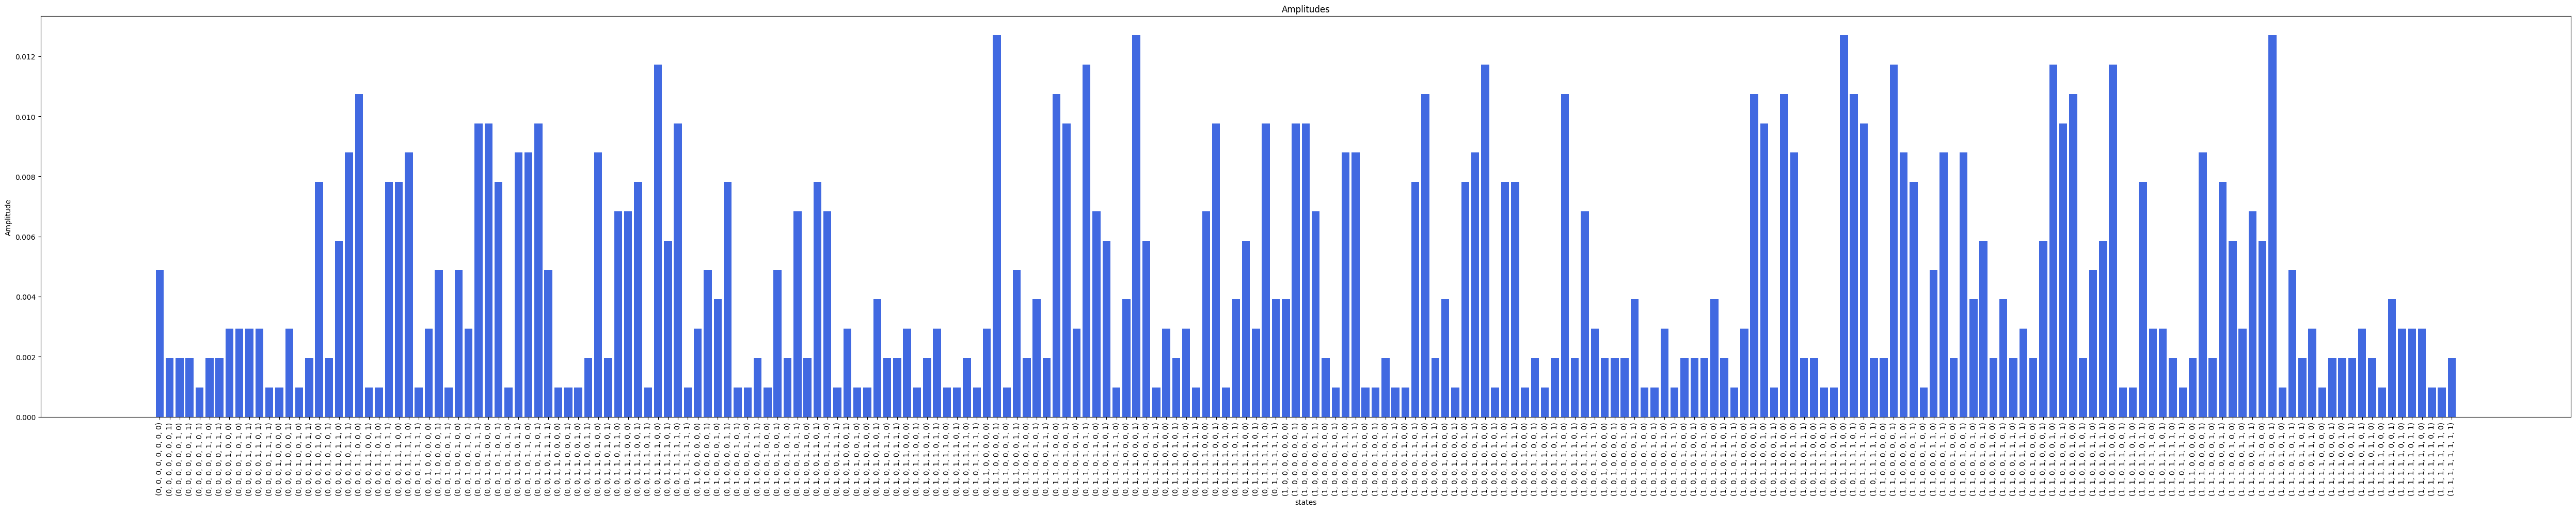

In [29]:
data = probs_from_counts(counts)

# Extract keys and values
keys = list(data.keys())
values = list(data.values())

# Convert keys to string representation for plotting
keys_str = [str(key) for key in keys]

# Create the bar plot
plt.figure(figsize=(50, 10))
plt.bar(keys_str, values, color='royalblue')

# Add title and labels
plt.title('Amplitudes')
plt.xlabel('states')
plt.ylabel('Amplitude')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

## Test

In [14]:
# Constrains and clause lists construction
constrains_list = []

for row, constrain in example_sudoku_4x4.rows_constraints.items():
    if row < 2:
        for number in constrain:
            for column in range(2):
                constrains_list.append((row*2 + column, number))

print(constrains_list)

[(0, 1), (1, 1), (0, 3), (1, 3), (2, 2), (3, 2), (2, 4), (3, 4)]


In [80]:
def constrait_circuit(value):
    bin_value = np.binary_repr(value, width=2)
    bin_list = [int(bit) for bit in bin_value]
    print(bin_list)

    constrait_circ = Circuit(3, name=f"check {value}")
    constrait_circ.X(2)

    for i, bit in enumerate(bin_list):
        if bit == 0:
            constrait_circ.X(i)

    constrait_circ.CCX(0, 1, 2)

    return CircBox(constrait_circ)

check = constrait_circuit(3)

circ = Circuit(4)
circ.add_gate(check, [0, 1, 3])
draw(circ)


[1, 1]
